In [39]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from scipy.stats.mstats import normaltest # D'Agostino K^2 Test for checking whether the data is normally distributed or not using pvalues
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency,shapiro, fisher_exact

import warnings
warnings.filterwarnings('ignore')

In [40]:
df = pd.read_csv("Salary_dataset.csv")
df.head()

,Unnamed: 0,YearsExperience,Salary
0,0,1.2,39344.0
1,1,1.4,46206.0
2,2,1.6,37732.0
3,3,2.1,43526.0
4,4,2.3,39892.0


In [41]:
df.drop('Unnamed: 0' , axis=1, inplace=True)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   YearsExperience  30 non-null     float64
 1   Salary           30 non-null     float64
dtypes: float64(2)
memory usage: 612.0 bytes


In [43]:
df.duplicated().any()

False

<Axes: xlabel='YearsExperience', ylabel='Salary'>

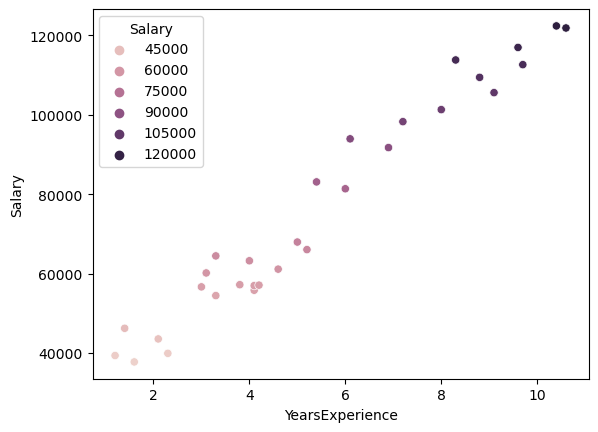

In [44]:
sns.scatterplot(data=df, x='YearsExperience', y='Salary', hue='Salary')

<Axes: xlabel='Salary', ylabel='Density'>

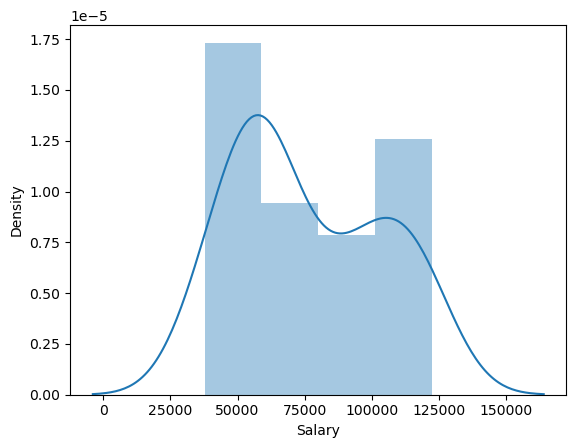

In [45]:
sns.distplot(df.Salary)

The target variable i.e., Salary is not normally distributed, let's check out few transformations using D'Agostinos K^2 Test to get to the normal distribution of the target feature

Log Transformation

<Axes: xlabel='Salary', ylabel='Density'>

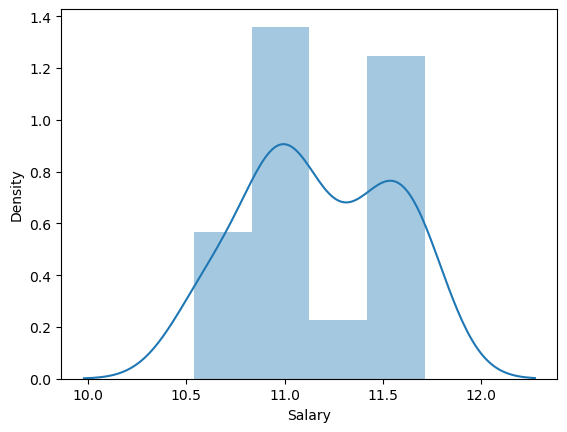

In [46]:
salary_log_tran = np.log(df.Salary)
sns.distplot(salary_log_tran)

In [47]:
normaltest(salary_log_tran)

NormaltestResult(statistic=5.4495091306914505, pvalue=0.0655622920019806)

Usually the more the pvalue, the closer the variable to the normal distribution. More specifically, we fail to reject the null hypothesis if the pvalue > 0.05, and the null hypothesis here being the data is normally distributed.

Since the pvalue is low, let's check out the other types of transformation as well.

Square Root Tranformation

<Axes: xlabel='Salary', ylabel='Density'>

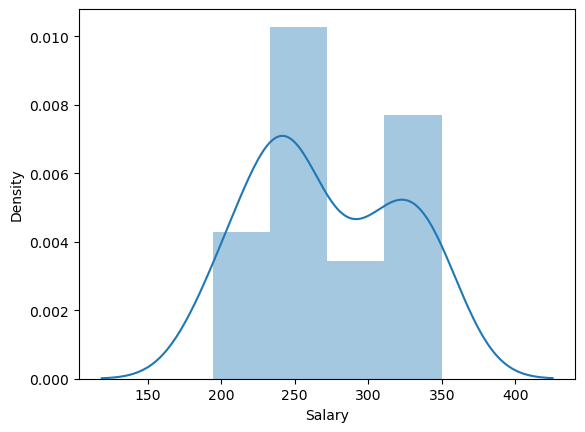

In [48]:
salary_sqrt_tran = np.sqrt(df.Salary)
sns.distplot(salary_sqrt_tran)

In [49]:
normaltest(salary_sqrt_tran)

NormaltestResult(statistic=7.622717734816249, pvalue=0.022118102957778864)

# Since the pvalue is < 0.05, we reject the null hypothesis, that is the data is not normally distributed.

BoxCox Tranformation

<Axes: ylabel='Density'>

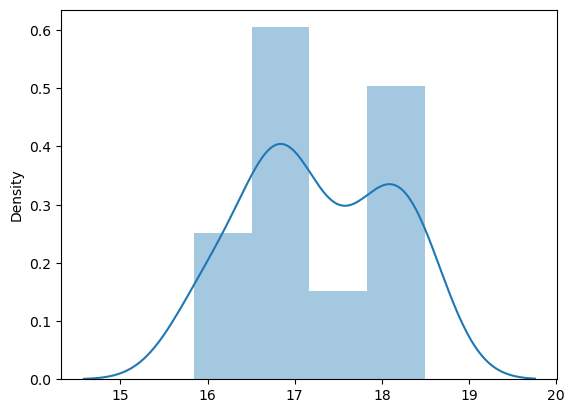

In [50]:
salary_bc_tran, lam = boxcox(df.Salary)
sns.distplot(salary_bc_tran)

In [51]:
normaltest(salary_bc_tran)

NormaltestResult(statistic=5.832932012183716, pvalue=0.05412462581176618)

Conclusion: Since the pvalue > 0.05, we fail to reject the null hypothesis and conclude that the data is normally distributed with boxcox transformation

Testing Regression

In [52]:
stat, p = shapiro(df['YearsExperience'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05 
if p > alpha:
      print('YearsExperience feature distribution looks normal (fail to reject H0)')
else:
    print('YearsExperience feature distribution does not look normal (reject H0)')
    




Statistics=0.942, p=0.103
YearsExperience feature distribution looks normal (fail to reject H0)


In [53]:
import warnings
import scipy.stats as st
def get_best_distribution(df):
    dist_names = ["norm", 
                  "exponweib",
                  "pareto", 
                  "weibull_max", 
                  "weibull_min",
                  "skewnorm",
                  "norminvgauss",
                  "powernorm",
                  "uniform"]
    
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(df)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(df, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value
    print(" ")
    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

In [54]:
get_best_distribution(df['YearsExperience'])

p value for norm = 0.599211531361924
p value for exponweib = 0.6747684060575618
p value for pareto = 0.24770100802906858
p value for weibull_max = 5.156438235448925e-08
p value for weibull_min = 0.9438176063390812
p value for skewnorm = 0.8089990739794852
p value for norminvgauss = 0.9170884951366863
p value for powernorm = 0.8470553245006611
p value for uniform = 0.4385480138032658
 
Best fitting distribution: weibull_min
Best p value: 0.9438176063390812
Parameters for the best fit: (1.598601715309133, 0.8929388124633428, 5.023081565968338)


In [55]:
linearReg = LinearRegression()

In [56]:
X = np.array(df['YearsExperience'])
Y = df['Salary']

In [57]:
print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")

X shape: (30,)
Y shape: (30,)


In [58]:
def to_2D(data):
    return data.reshape(data.shape[0], -1)
    

Create Polynomial Features for the X data

In [59]:
pf = PolynomialFeatures(degree=2, include_bias=False)
X_pf = pf.fit_transform(to_2D(X))

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X_pf, Y, test_size=0.2, random_state=15)

In [61]:
s = StandardScaler()
X_train_s = s.fit_transform(X_train)


In [62]:
y_train_bc, lam = boxcox(y_train)

In [63]:
linearReg.fit(X_train_s, y_train_bc)
X_test_s = s.transform(X_test)
y_pred_bc = linearReg.predict(X_test_s)

Calculating the r2 score
But before the we need to perform inverse tranformation on the predicted y values

In [64]:
y_pred_tran = inv_boxcox(y_pred_bc, lam)
r2_score(y_test, y_pred_tran)

0.8805258889394869

Our model is 88% accurate in predicting the values

In [65]:
X_sklearn = np.array(X)
Y_sklearn = np.array(Y)
X_sklearn = X_sklearn.reshape(-1,1)
Y_sklearn = Y_sklearn.reshape(-1,1)
print(f"Shape of new X: {X_sklearn.shape}")
print(f"Shape of new Y: {Y_sklearn.shape}")
X_logged = s.fit_transform(X_sklearn)
Y_logged = s.fit_transform(Y_sklearn)

Shape of new X: (30, 1)
Shape of new Y: (30, 1)


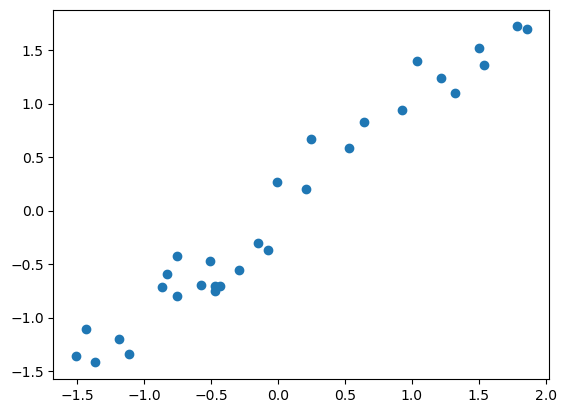

In [66]:
plt.scatter(X_logged, Y_logged, marker="o")

# Training

In [67]:
linearReg.fit(X_sklearn, Y_sklearn)


LinearRegression()

In [68]:
beta0, beta1 = linearReg.coef_, linearReg.intercept_
print(f"Slope = {beta0}")
print(f"Intercept = {beta1}")

Slope = [[9449.96232146]]
Intercept = [24848.20396652]


# Prediction

In [69]:
new_x_data = np.array(1.2)
new_x_data = new_x_data.reshape(-1,1)
predicted = linearReg.predict(new_x_data)
print(f"Predicted Salary = {str(predicted).strip('[]')}")

Predicted Salary = 36188.15875227


In [70]:
Y_predicted = linearReg.predict(X_sklearn)

In [71]:
Y_predicted = pd.DataFrame(Y_predicted)
Y_predicted.rename(columns={0:'Predicted_Salary'}, inplace=True)
Y_predicted.head()

,Predicted_Salary
0,36188.158752
1,38078.151217
2,39968.143681
3,44693.124842
4,46583.117306


In [72]:
df = pd.concat([df.reset_index(drop=True), Y_predicted], axis=1)
df.head()

,YearsExperience,Salary,Predicted_Salary
0,1.2,39344.0,36188.158752
1,1.4,46206.0,38078.151217
2,1.6,37732.0,39968.143681
3,2.1,43526.0,44693.124842
4,2.3,39892.0,46583.117306


<function matplotlib.pyplot.show(close=None, block=None)>

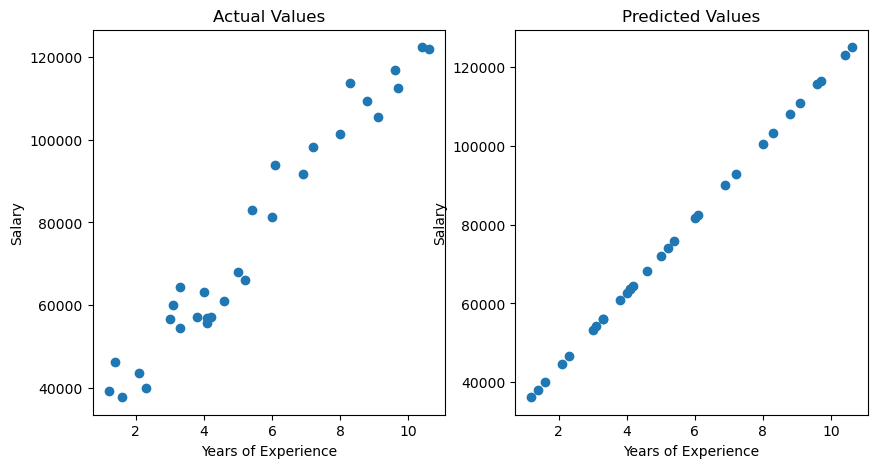

In [73]:
fig, (actual, predicted) = plt.subplots(1, 2, figsize=(10,5))

actual.plot(X_sklearn, Y_sklearn, 'o')
# actual.plot(X_sklearn, beta1*X_sklearn + beta0, color='red')
predicted.plot(X_sklearn, Y_predicted, 'o')

actual.set(title='Actual Values', xlabel='Years of Experience', ylabel='Salary')
predicted.set(title='Predicted Values', xlabel='Years of Experience', ylabel='Salary')

plt.show

In [74]:
loss_function = np.sum((Y_predicted - Y_sklearn) ** 2)
loss_function

Predicted_Salary    9.381286e+08
dtype: float64

In [75]:
def pred(X, linearReg):
    X_2d = X.reshape(-1,1)
    Y = linearReg.predict(X_2d)
    return Y

In [76]:
new_data_points = np.array([3, 10, 12, 4.2]).astype(int)
print(f"Test data: \n{new_data_points}")
print(f"Predicted values: \n{pred(new_data_points, linearReg).T}")

Test data: 
[ 3 10 12  4]
Predicted values: 
[[ 53198.09093089 119347.82718107 138247.75182398  62648.05325234]]
